# Make plots of layer orientation

Requires master_orientation.py has already been run

## Import packages

In [1]:
# general
import numpy as np
import pandas as pd
import math
from scipy import stats

# plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# math
from statsmodels.stats.weightstats import DescrStatsW

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Set Filepaths

In [2]:
path_to_angles = '../../data/angles/'
path_to_figures = '../../../figures/paper_figures/'

# set path to final figure
path_to_final_fig = '../../../final_submission_try2/'

## Load Angle Data

Requires that master_orientation.py has already been run

In [3]:
alhic2302 = pd.read_pickle(path_to_angles+'alhic2302_angles.df')
alhic2201 = pd.read_pickle(path_to_angles+'alhic2201_angles.df')

## Adjust Aparent Dip for geometry

All aparent dip is calculated in the same reference frame. However, we need to flip one of the two faces for both cores to achieve our definition of a positive dip as sloping down from the center of the core. This means flipping 't' on ALHIC2201 and 'l' on ALHIC2302

In [4]:
# multiply all angles in 'AC-l-angles' by -1 in alhic2302
for index,row in alhic2302.iterrows():
    alhic2302.at[index,'AC-l-angles'] = list(map(lambda x: x * -1, row['AC-l-angles']))

# multiply all angles in 'AC-t-angles' by -1 in alhic2201
for index,row in alhic2201.iterrows():
    alhic2201.at[index,'AC-t-angles'] = list(map(lambda x: x * -1, row['AC-t-angles']))

## Calculate True Angle Orientations

In [5]:
# define function to calculate true dip, dip direction, and score

def calc_dip(df,face):

    dip = []
    dip_direction = []
    dip_score = []
    for index,row in df.iterrows():

        # pull out values from the side (first check there are three)
        if row['AC-'+face+'-angles'] != None and len(row['AC-'+face+'-angles']) > 2:
            add_nan = False
            side_angle = np.array(row['AC-'+face+'-angles']) * np.pi/180
            side_score = np.array(row['AC-'+face+'-scores'])
            side_length = np.array(row['AC-'+face+'-length'])
        else:
            add_nan = True

        # pull out values from the top
        if row['AC-t-angles'] != None and len(row['AC-t-angles']) > 2:
            top_angle = np.array(row['AC-t-angles']) * np.pi/180
            top_score = np.array(row['AC-t-scores'])
            top_length = np.array(row['AC-t-length'])
        else:
            add_nan = True
        

        # set true angle to nan if we don't have enough data
        if add_nan:
            dip_score_ind = [np.nan]
            dip_dir_ind = [np.nan]
            dip_ind = [np.nan]
        
        # else, calculate dip and save to list
        else:

            # assign delta 1 and delta 2
            if face == 'l':
                d1 = top_angle
                d2 = side_angle
                
                d1_score = top_score * top_length
                d2_score = side_score * side_length
                
            elif face == 'r':
                
                d1 = side_angle
                d2 = top_angle

                d1_score = side_score * side_length
                d2_score = top_score * top_length
            else:
                print('Error: face must be either t or l')
                break

            # make empty lists
            dip_score_ind = []
            dip_dir_ind = []
            dip_ind = []

            for i in range(len(d2)):
                for j in range(len(d1)):

                    # calculate dip score
                    ds = d1_score[j] * d2_score[i]
                    dip_score_ind.append(ds)

                    # calculate dip direction
                    dd = np.arctan(np.tan(d2[i])/np.tan(d1[j])) 
                    

                    # calculate true dip
                    d = np.arctan(np.tan(d1[j])/np.cos(dd))
                    
                    # now deal with cases where the dip is negative
                    if d<0:
                        d = d*-1
                        dd = dd + np.pi
                        #dd = dd * -1
                    
                    # store values
                    dip_dir_ind.append(dd* 180 / np.pi)
                    dip_ind.append(d* 180 / np.pi)


        # append to lists
        dip.append(dip_ind)
        dip_direction.append(dip_dir_ind)
        dip_score.append(dip_score_ind)

    df['AC-dip'] = dip
    df['AC-dip-direction'] = dip_direction
    df['AC-dip-score'] = dip_score


    return df

In [6]:
alhic2302 = calc_dip(alhic2302,'l')
alhic2201 = calc_dip(alhic2201,'r')

In [7]:
def sph_to_cart(delta_deg, alpha_deg):
    """Convert (dip, azimuth) to unit vector [x,y,z]."""
    d = np.deg2rad(delta_deg)
    a = np.deg2rad(alpha_deg)
    return np.column_stack([np.cos(d)*np.sin(a), np.cos(d)*np.cos(a), np.sin(d)])


In [8]:
def weighted_spherical_median(vectors, weights, tol=1e-6, max_iter=1000):

    """Weighted Weiszfeld algorithm on the sphere."""
    m = np.average(vectors, axis=0, weights=weights)
    m /= np.linalg.norm(m)

    for _ in range(max_iter):

        dots = np.clip(vectors.dot(m), -1, 1)
        
        angles = np.arccos(dots)
        
        if np.any(angles < tol):
            print("Warning: some vectors are too close to the median, returning one of them.")
            return vectors[np.argmin(angles)]
        w_ang = weights / angles
        m_new = (w_ang[:, None] * vectors).sum(axis=0)
        m_new /= np.linalg.norm(m_new)
        if np.linalg.norm(m_new - m) < tol:
            m = m_new
            break
        m = m_new

    return m

def weighted_spherical_mean(vectors, weights):
    """Weighted spherical mean."""
    m = np.average(vectors, axis=0, weights=weights)
    m /= np.linalg.norm(m)

    return m

In [9]:
# Calculate the angular radius for a given weight fraction
def angular_radius_for_weight_fraction(vectors, weights, center, fraction=0.5):
    # compute angles between each vector and the center
    dots = np.clip(vectors.dot(center), -1, 1)
    angles = np.arccos(dots)
    # sort by angle and accumulate weights
    order = np.argsort(angles)
    cumw = np.cumsum(np.array(weights)[order])
    # find the index where cumulative weight reaches the target fraction
    idx = np.searchsorted(cumw, fraction * cumw[-1])
    return np.degrees(angles[order][idx])

def calc_median_dip(core, core_name):
    """
    Calculate the median dip and azimuth of the planes in a core.
    The function takes a dataframe with the angles and scores of the planes
    and returns a dataframe with the median dip and azimuth of the planes.
    """
    # create empty lists to store the results
    dds = []
    dips = []
    depths = []
    flags = []

    for index, row in core.iterrows():

        vectors = []
        weights = []

        # extract angles and scores
        angles = row['AC-dip']
        dir = row['AC-dip-direction']
        scores = row['AC-dip-score']

        # check if angles and scores are not NaN
        if angles is not None and scores is not None:

            for a,d,s in zip(angles, dir, scores):

                # create a vector for each plane
                vector = sph_to_cart(a, d)
                vectors.append(vector[0])

                # weights
                weights.append(s)

        # convert list of 3D vectors to numpy array
        vectors = np.array(vectors)

        # calculate the median vector
        m = weighted_spherical_median(vectors,weights)

        # compute the dip and azimuth of the median vector
        dip = np.arcsin(m[2])#np.arctan2(np.linalg.norm(m[:2]), m[2])
        dips.append(np.rad2deg(dip))
        dd = np.arctan2(m[1], m[0])
        dd = np.rad2deg(dd)



        # calculate the angular radius for the median vector
        radius = angular_radius_for_weight_fraction(vectors, weights, m, fraction=0.5)
        if radius > 8:
            flags.append(True)
        else:
            flags.append(False)
        print(f"Angular radius for {core_name} at section {row['section']}: {radius:.2f} degrees")

        # adjust the dip direction based on the core name
        if core_name == 'alhic2201':
            dd = dd-90
        if dd < 0:
            dd += 360
        if dd>360:
            dd -= 360
            
        # flip the dip direction
        dd = 360 - dd
        dds.append(dd)


        # save the depth and core name from df
        depths.append(row['depth'])

    # create a dataframe with the results
    results = pd.DataFrame({'depth': depths, 'dip': dips, 'dip_direction': dds, 'flag_uncertainty': flags})
    
    # save the results to a .csv file
    results.to_csv(path_to_angles+core_name+'_median_dip.csv', index=False)

    # add the results the original core dataframe
    core['vector-dip-median'] = results['dip']
    core['vector-dip-direction-median'] = results['dip_direction']
    core['vector-flag-uncertainty'] = results['flag_uncertainty']

    return results, core


#for core,core_name in zip([alhic2302,alhic2201],['alhic2302','alhic2201']):

alhic2302_vectorresults, alhic2302= calc_median_dip(alhic2302,'alhic2302')
alhic2201_vectorresults, alhic2201 = calc_median_dip(alhic2201,'alhic2201')


Angular radius for alhic2302 at section 10: 9.66 degrees
Angular radius for alhic2302 at section 12: 1.55 degrees
Angular radius for alhic2302 at section 13: 1.41 degrees
Angular radius for alhic2302 at section 14: 4.87 degrees
Angular radius for alhic2302 at section 15: 2.59 degrees
Angular radius for alhic2302 at section 16: 22.56 degrees
Angular radius for alhic2302 at section 17: 2.29 degrees
Angular radius for alhic2302 at section 18: 0.26 degrees
Angular radius for alhic2302 at section 19: 0.93 degrees
Angular radius for alhic2302 at section 20: 8.96 degrees
Angular radius for alhic2302 at section 21: 1.56 degrees
Angular radius for alhic2302 at section 22: nan degrees
Angular radius for alhic2302 at section 23: 1.63 degrees
Angular radius for alhic2302 at section 24: 1.31 degrees
Angular radius for alhic2302 at section 25: 2.20 degrees
Angular radius for alhic2302 at section 26: 5.37 degrees
Angular radius for alhic2302 at section 27: 0.93 degrees
Angular radius for alhic2302 at

# Dip Angle Plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


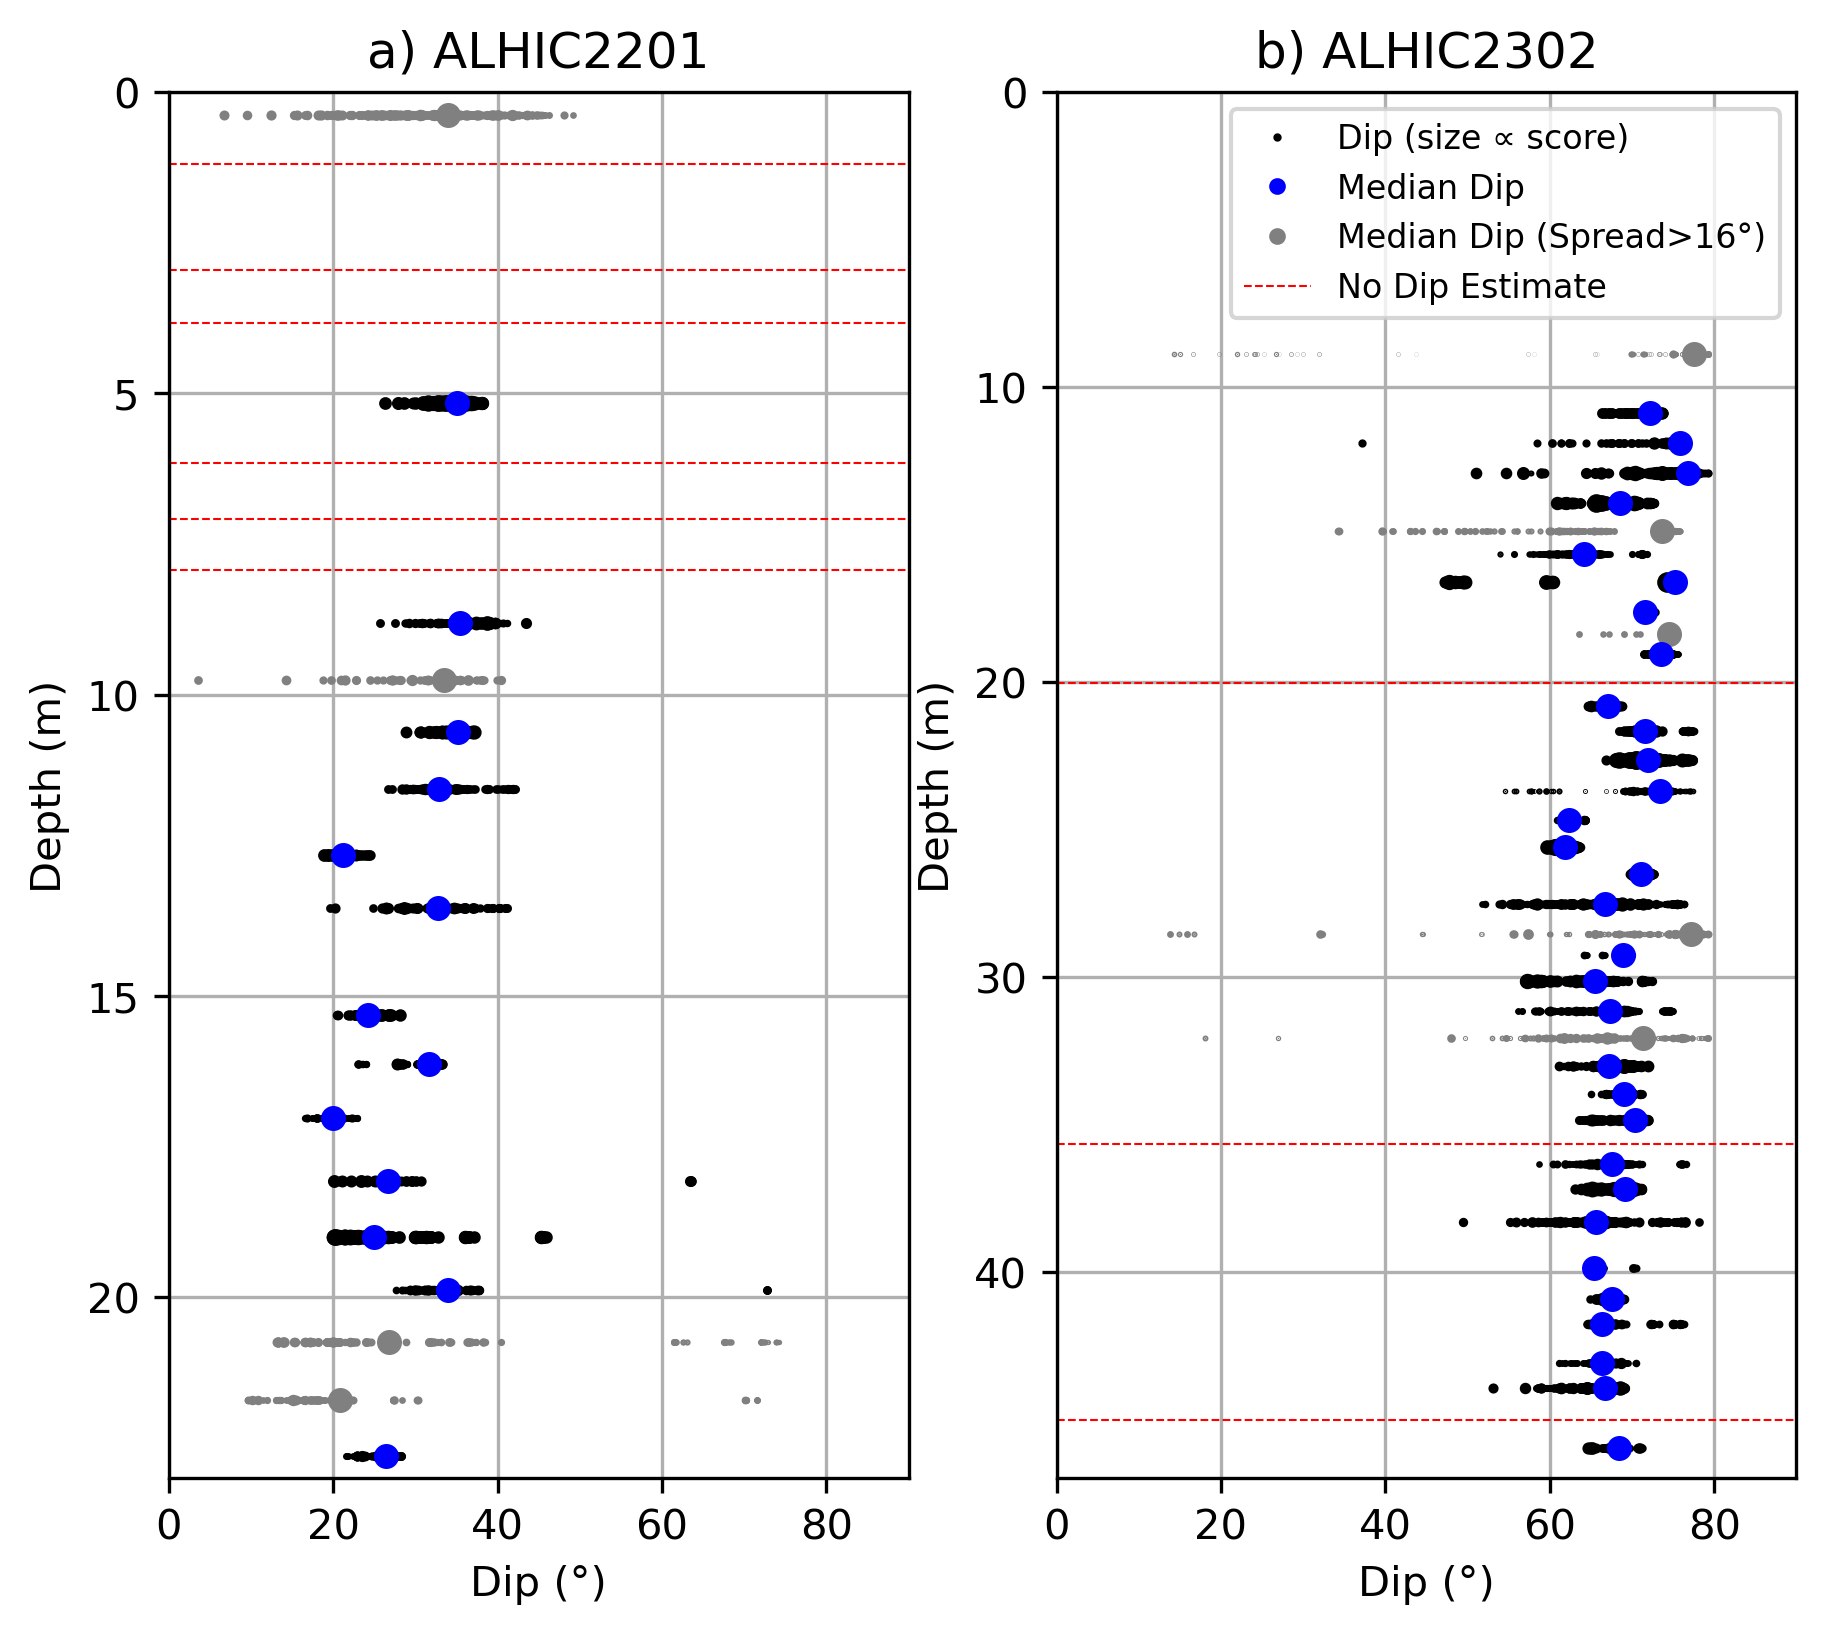

In [ ]:
# make figure
fig, ax = plt.subplots(1,2,figsize=(7,6),dpi=300)

# axis labels
for a in ax:
    a.set_ylabel('Depth (m)')
    a.set_xlabel('Dip (°)')
    a.set_xlim(0,90)
    a.grid(True)
ax[0].set_title('a) ALHIC2201')
ax[1].set_title('b) ALHIC2302')
ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[0].set_ylim(23,0)
ax[1].set_ylim(47,0)

def plot_dip(df,ax):
    for index,row in df.iterrows():

         # pull out values for this section
        d = row['depth']
        dip = np.array(row['AC-dip'])
        scores = np.array(row['AC-dip-score'])

        if not row['vector-flag-uncertainty']:

            # check if row dip is nan
            if np.isnan(dip).all():
                ax.plot([0,90],[d,d],'r--',linewidth=0.5)
            else:

                # plot dip (individual points)
                for i in range(len(dip)):
                    ax.plot(dip[i],d,'k.',markersize=scores[i]*10)

            # plot median dip
            ax.plot(row['vector-dip-median'],row['depth'],'bo',markersize=5)

        else:
            # plot median dip
            ax.plot(row['vector-dip-median'],row['depth'],'o',markersize=5,color='grey')

            # check if row dip is nan
            if np.isnan(dip).all():
                ax.plot([0,90],[d,d],'r--',linewidth=0.5)
            else:

                # plot dip (individual points)
                for i in range(len(dip)):
                    ax.plot(dip[i], d, '.', color='grey', markersize=scores[i]*10)


# add legend (to left subplot only)
ax[1].plot([],[],'k.',markersize=2,label='Dip (size ∝ score)')
ax[1].plot([],[],'b.',label='Median Dip')
ax[1].plot([],[],'.',color='grey',linewidth=3,label='Median Dip (Spread>16°)')
ax[1].plot([],[],'r--',linewidth=0.5,label='No Dip Estimate')
ax[1].legend(loc='upper right', fontsize=8)

plot_dip(alhic2201,ax[0])
plot_dip(alhic2302,ax[1])

# save figure
fig.savefig(path_to_final_fig+'JOG-2024-0148-Figure7.eps', dpi=300)

# Dip Direction plot

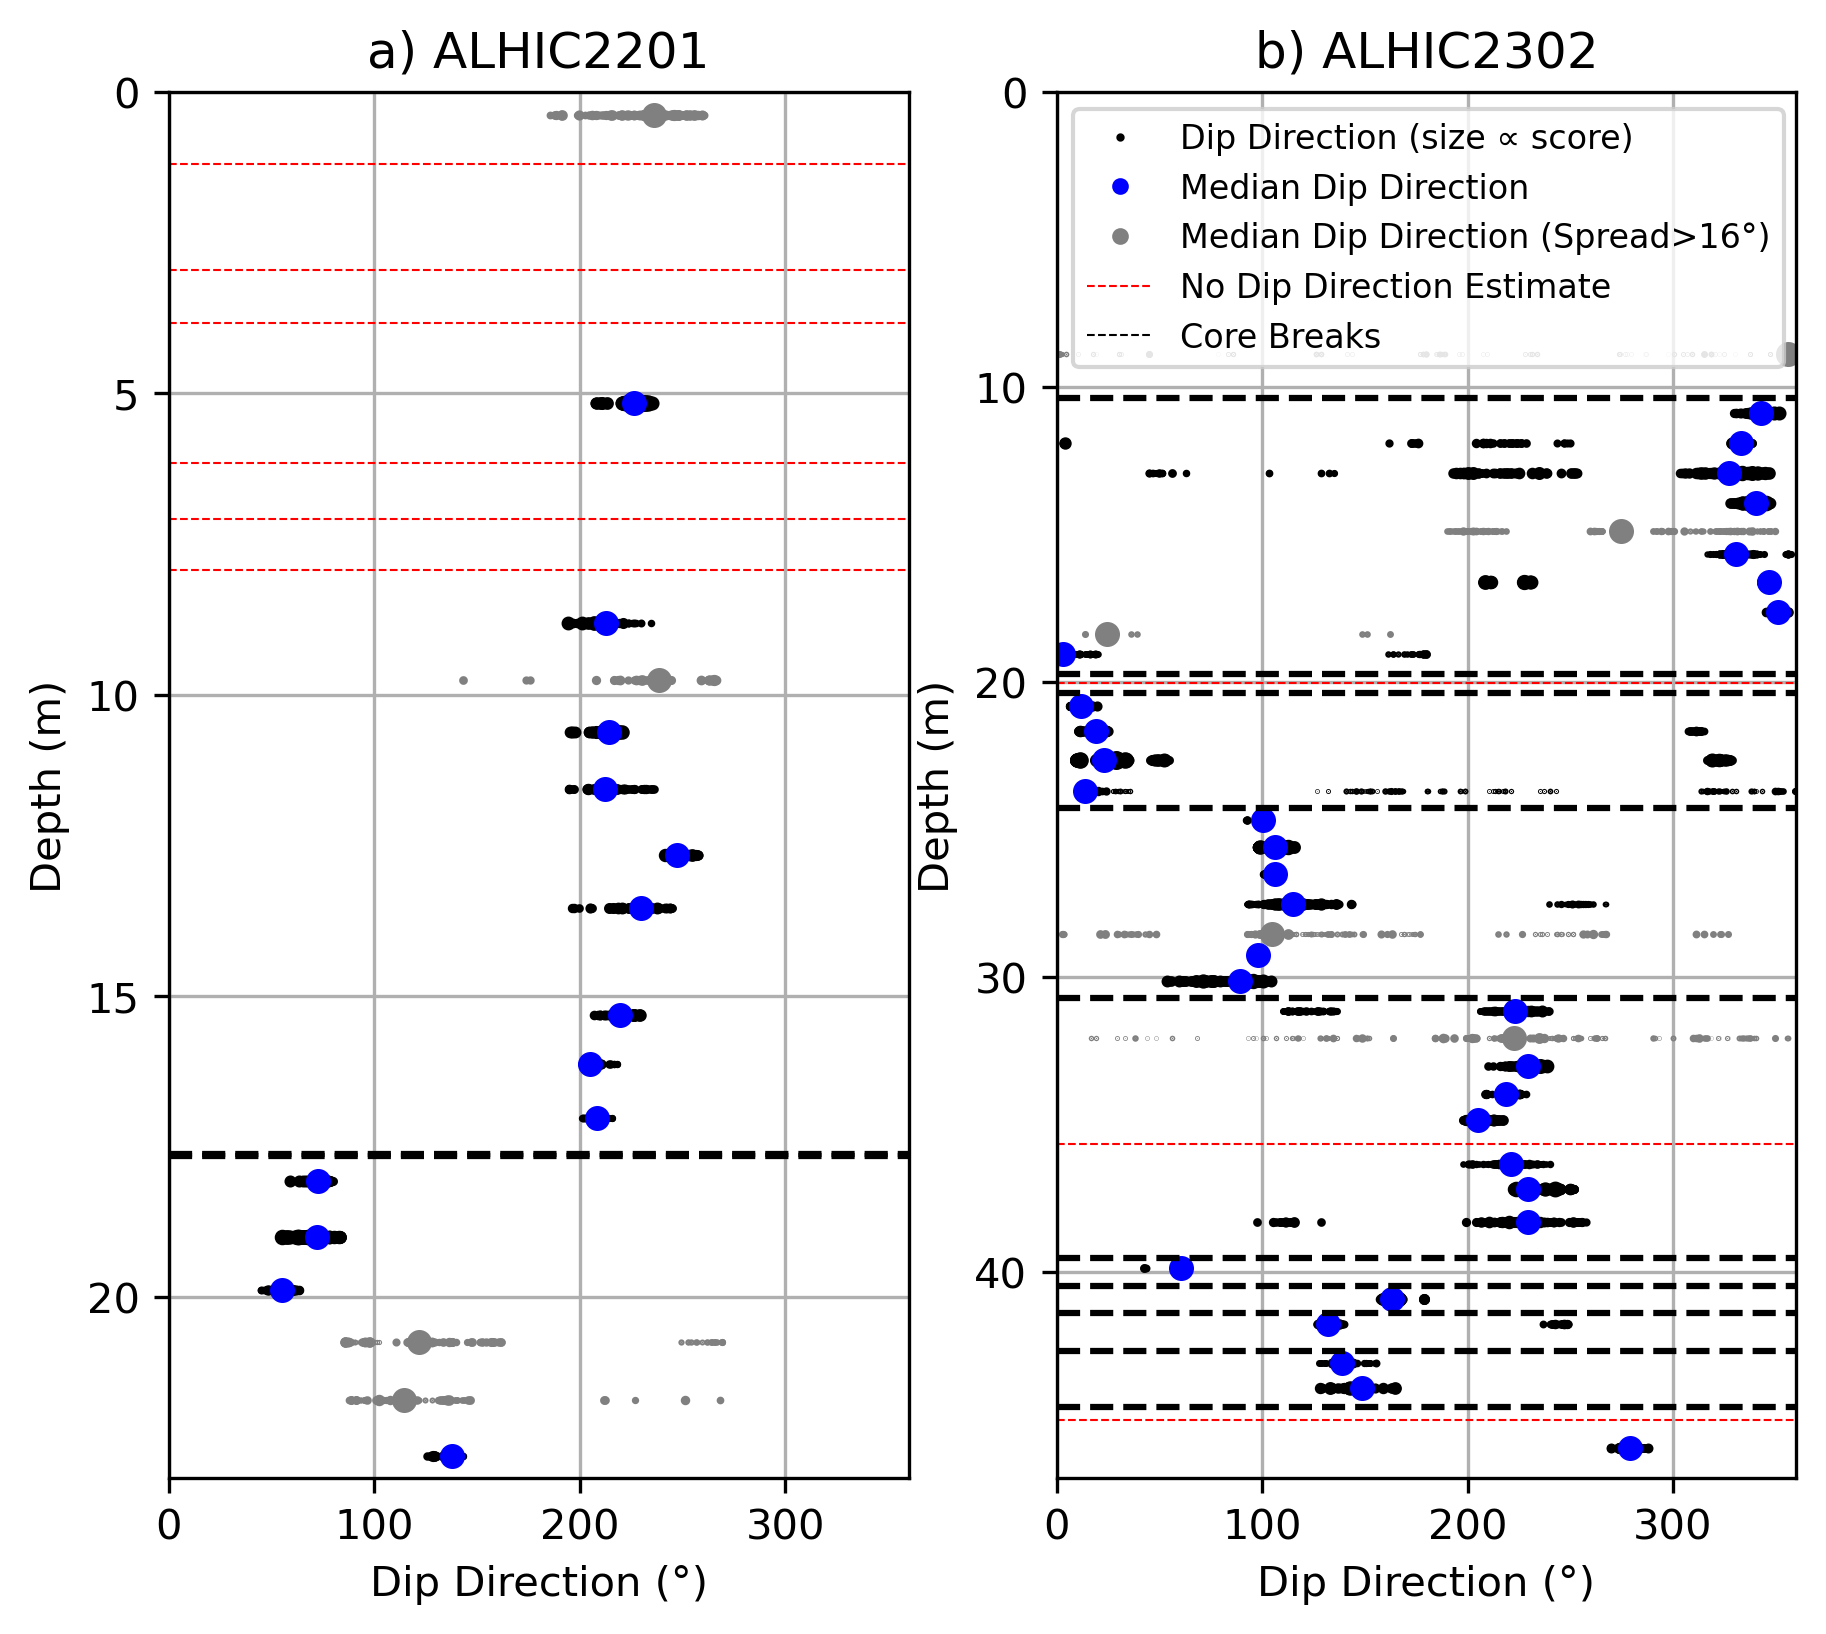

In [11]:
alhic2201_breaks = [17.62,17.65,24.08]
alhic2302_breaks = [10.37,19.73,20.39,24.28,30.72,39.53,40.47,41.39,42.7,44.57]

# make figure
fig, ax = plt.subplots(1,2,figsize=(7,6),dpi=300)

# axis labels
for a in ax:
    a.set_ylabel('Depth (m)')
    a.set_xlabel('Dip Direction (°)')
    a.set_xlim(0,360)
    a.grid(True)
ax[0].set_title('a) ALHIC2201')
ax[1].set_title('b) ALHIC2302')
ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[0].set_ylim(23,0)
ax[1].set_ylim(47,0)

def plot_dd(df,ax,breaks,core):
    for index,row in df.iterrows():

         # pull out values for this section
        d = row['depth']
        dip = np.array(row['AC-dip'])
        dd = np.array(row['AC-dip-direction'])
        scores = np.array(row['AC-dip-score'])

        # subtract 90 from dip direction if core is alhic2302
        if core == 'alhic2302':
            dd = dd - 90
            # normalize each dd into [0,360)
            dd = np.mod(dd, 360)



        if not row['vector-flag-uncertainty']:

            # check if row dip is nan
            if np.isnan(dip).all():
                ax.plot([0,360],[d,d],'r--',linewidth=0.5)
            else:

                # plot dip (individual points)
                for i in range(len(dip)):
                    ax.plot(dd[i],d,'k.',markersize=scores[i]*10)

            # plot median dip
            ax.plot(row['vector-dip-direction-median'],row['depth'],'bo',markersize=5)

        else:
            # plot median dip
            ax.plot(row['vector-dip-direction-median'],row['depth'],'o',markersize=5,color='grey')

            # check if row dip is nan
            if np.isnan(dip).all():
                ax.plot([0,360],[d,d],'r--',linewidth=0.5)
            else:

                # plot dip (individual points)
                for i in range(len(dip)):
                    ax.plot(dd[i], d, '.', color='grey', markersize=scores[i]*10)
    
# plot core breaks
    for b in breaks:
        ax.plot([0, 360], [b, b], 'k--')

# add a legend (to left subplot only)
ax[1].plot([],[],'k.',markersize=2,label='Dip Direction (size ∝ score)')
ax[1].plot([],[],'b.',label='Median Dip Direction')
ax[1].plot([],[],'.',color='grey',linewidth=3,label='Median Dip Direction (Spread>16°)')
ax[1].plot([],[],'r--',linewidth=0.5,label='No Dip Direction Estimate')
ax[1].plot([],[],'k--',linewidth=0.5,label='Core Breaks')
ax[1].legend(loc='upper left', fontsize=8)
        

plot_dd(alhic2201,ax[0],alhic2201_breaks,'alhic2201')
plot_dd(alhic2302,ax[1],alhic2302_breaks,'alhic2302')

# save figure
fig.savefig(path_to_final_fig+'JOG-2024-0148.Figure9.png', dpi=300)

# Dip Trend Plot

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


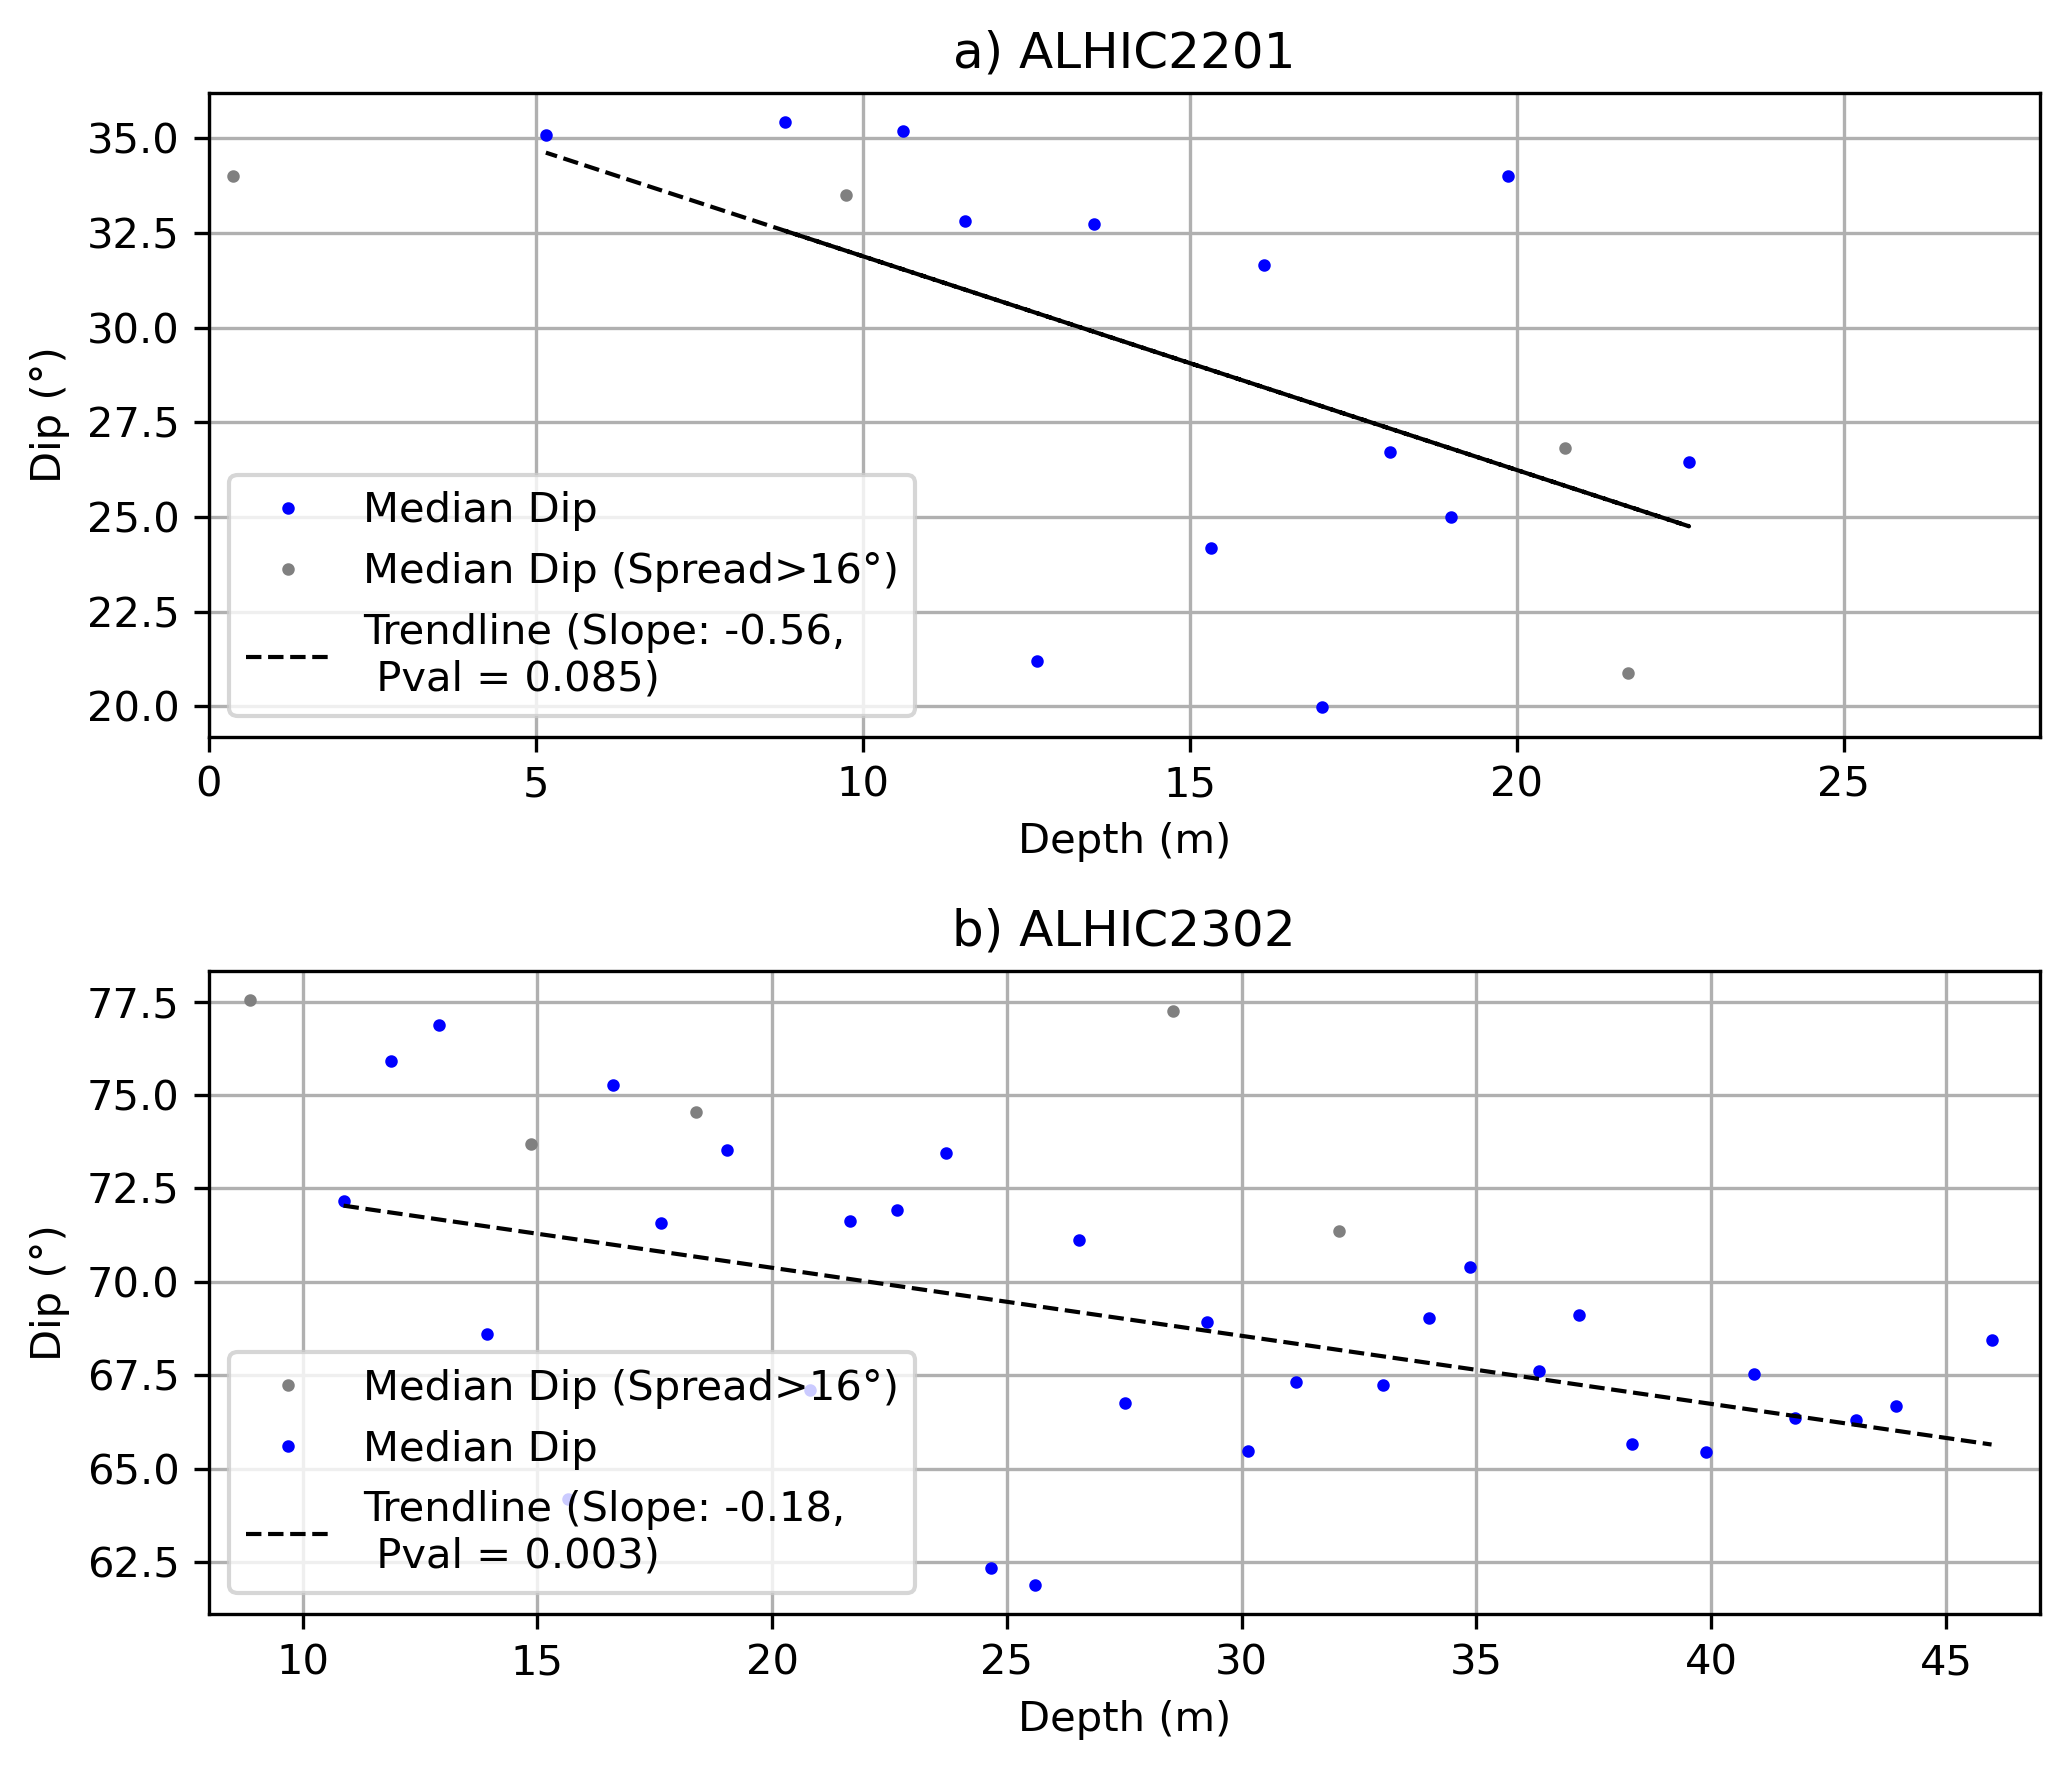

In [12]:
def t_test_trend(df):
    """
    Perform a t-test on the slope of the trend of the dip angle in a core.
    Uses only data where row['vector-flag-uncertainty'] is False.
    Returns the slope, intercept, p-value, depth, and dip.
    """
    # filter the dataframe to only include rows where vector-flag-uncertainty is False
    df_filtered = df[df['vector-flag-uncertainty'] == False]
    if df_filtered.empty:
        return None, None, None, None, None
    
    # filter out rows where vector-dip-median is NaN
    df_filtered = df_filtered[~df_filtered['vector-dip-median'].isna()]
    if df_filtered.empty:
        return None, None, None, None, None
    
    # extract the depth and dip values
    depth = df_filtered['depth'].values
    dip = df_filtered['vector-dip-median'].values
    if len(depth) < 2 or len(dip) < 2:
        return None, None, None, None, None
    
    # perform a linear regression on the depth and dip values
    slope, intercept, r_value, p_value, std_err = stats.linregress(depth, dip)
   
    return slope, intercept, p_value, depth, dip

# calculate t-test for alhic2201 and alhic2302
alhic2201_slope, alhic2201_intercept, alhic2201_p_value, alhic2201_depth, alhic2201_dip = t_test_trend(alhic2201)
alhic2302_slope, alhic2302_intercept, alhic2302_p_value, alhic2302_depth, alhic2302_dip = t_test_trend(alhic2302)

# make figure
fig, ax = plt.subplots(2,1,figsize=(7,6),dpi=300)
for a in ax:
    a.set_xlabel('Depth (m)')
    a.set_ylabel('Dip (°)')
    a.set_xlim(0,90)
    a.grid(True)
ax[0].set_title('a) ALHIC2201')
ax[1].set_title('b) ALHIC2302')
ax[0].set_xlim(0,28)
ax[1].set_xlim(8,47)

# plot the data points (make them grey if uncertainty is True)
def plot_trend(df,ax):
    goodflag = True
    badflag = True
    for index,row in df.iterrows():

        # pull out values for this section
        d = row['depth']
        dip = row['vector-dip-median']
        flag = row['vector-flag-uncertainty']

        if not flag:
            ax.plot(d,dip,'b.',markersize=4,label='Median Dip' if goodflag else "")
            goodflag = False
        else:
            ax.plot(d,dip,'.',color='grey',markersize=4,label='Median Dip (Spread>16°)' if badflag else "")
            badflag = False

    # plot the trend line
    slope, intercept, p_value, depth, dip = t_test_trend(df)
    if slope is not None:
        label = f'Trendline (Slope: {slope:.2f}, \n Pval = {p_value:.3f})'
        ax.plot(depth, slope*depth + intercept, 'k--', linewidth=1,label=label)
        # ax.text(0.05, 0.95, f'p-value: {p_value:.3f}', transform=ax.transAxes, fontsize=8,
        #         verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

    ax.legend(loc='lower left')

plot_trend(alhic2201,ax[0])
plot_trend(alhic2302,ax[1])

# set tight layout
plt.tight_layout()

# save figure
fig.savefig(path_to_final_fig+'JOG-2024-0148.Figure8.png', dpi=300)


In [13]:
# find average dip in ALHIC2201 above the first core break
alhic2201_above_break = alhic2201[alhic2201['depth'] < alhic2201_breaks[0]]

# filter for where the flag is False
alhic2201_above_break = alhic2201_above_break[alhic2201_above_break['vector-flag-uncertainty'] == False]


average_dip_direction = alhic2201_above_break['vector-dip-direction-median'].mean()
std_dip_direction = alhic2201_above_break['vector-dip-direction-median'].std()
print("Average Dip Direction above the first orientation lost is "+str(round(average_dip_direction,1)))
print("Standard Deviation of Dip Direction above the first orientation lost is "+str(round(std_dip_direction,1)))

#Move into degrees east framework
o_line_azimuth = 59
dip_azimuth = o_line_azimuth - average_dip_direction

print("ALHIC2201 Dip azimuth is "+str(round((dip_azimuth+360)%360,1))+" degrees E of N")

Average Dip Direction above the first orientation lost is 219.5
Standard Deviation of Dip Direction above the first orientation lost is 13.3
ALHIC2201 Dip azimuth is 199.5 degrees E of N


In [14]:
# Report total number of sections and number of “good” (vector-flag-uncertainty=False) sections
print(f"Total number of sections in alhic2201: {len(alhic2201)}")
print(f"Total number of sections in alhic2201 where dip is nan: {len(alhic2201[alhic2201['vector-dip-median'].isna()])}")
n_good_2201 = ((~alhic2201['vector-flag-uncertainty']) & (~alhic2201['vector-dip-median'].isna())).sum()
print(f"Number of good sections in alhic2201: {n_good_2201}")

# duplicate the above for alhic2302
print(f"Total number of sections in alhic2302: {len(alhic2302)}")
print(f"Total number of sections in alhic2302 where dip is nan: {len(alhic2302[alhic2302['vector-dip-median'].isna()])}")
n_good_2302 = ((~alhic2302['vector-flag-uncertainty']) & (~alhic2302['vector-dip-median'].isna())).sum()
print(f"Number of good sections in alhic2302: {n_good_2302}")

# Median and standard deviation of the median dip for good sections
median_dip_2201 = alhic2201.loc[~alhic2201['vector-flag-uncertainty'], 'vector-dip-median'].mean()
std_dip_2201    = alhic2201.loc[~alhic2201['vector-flag-uncertainty'], 'vector-dip-median'].std()
median_dip_2302 = alhic2302.loc[~alhic2302['vector-flag-uncertainty'], 'vector-dip-median'].mean()
std_dip_2302    = alhic2302.loc[~alhic2302['vector-flag-uncertainty'], 'vector-dip-median'].std()

print(f"alhic2201 median dip (good): {median_dip_2201:.2f}° ± {std_dip_2201:.2f}°")
print(f"alhic2302 median dip (good): {median_dip_2302:.2f}° ± {std_dip_2302:.2f}°")

# combined percentage of good sections
total_sections      = len(alhic2201) + len(alhic2302)
total_good_sections = n_good_2201 + n_good_2302
pct_good = total_good_sections / total_sections * 100
print(f"Percentage of good sections overall: {pct_good:.1f}%")

# percentage of nan dips in alhic2201 and alhic2302 and combined
pct_nan_2201 = len(alhic2201[alhic2201['vector-dip-median'].isna()]) / len(alhic2201) * 100
pct_nan_2302 = len(alhic2302[alhic2302['vector-dip-median'].isna()]) / len(alhic2302) * 100
pct_nan_combined = (len(alhic2201[alhic2201['vector-dip-median'].isna()]) + len(alhic2302[alhic2302['vector-dip-median'].isna()])) / total_sections * 100
print(f"Percentage of NaN dips in alhic2201: {pct_nan_2201:.1f}%")
print(f"Percentage of NaN dips in alhic2302: {pct_nan_2302:.1f}%")
print(f"Percentage of NaN dips overall: {pct_nan_combined:.1f}%")

# percentage of sections with vector-flag-uncertainty=True
pct_uncertainty_2201 = alhic2201['vector-flag-uncertainty'].mean() * 100
pct_uncertainty_2302 = alhic2302['vector-flag-uncertainty'].mean() * 100
pct_uncertainty_combined = (alhic2201['vector-flag-uncertainty'].sum() + alhic2302['vector-flag-uncertainty'].sum()) / total_sections * 100
print(f"Percentage of sections with vector-flag-uncertainty=True in alhic2201: {pct_uncertainty_2201:.1f}%")
print(f"Percentage of sections with vector-flag-uncertainty=True in alhic2302: {pct_uncertainty_2302:.1f}%")
print(f"Percentage of sections with vector-flag-uncertainty=True overall: {pct_uncertainty_combined:.1f}%")

Total number of sections in alhic2201: 23
Total number of sections in alhic2201 where dip is nan: 6
Number of good sections in alhic2201: 13
Total number of sections in alhic2302: 39
Total number of sections in alhic2302 where dip is nan: 3
Number of good sections in alhic2302: 31
alhic2201 median dip (good): 29.26° ± 5.55°
alhic2302 median dip (good): 68.90° ± 3.74°
Percentage of good sections overall: 71.0%
Percentage of NaN dips in alhic2201: 26.1%
Percentage of NaN dips in alhic2302: 7.7%
Percentage of NaN dips overall: 14.5%
Percentage of sections with vector-flag-uncertainty=True in alhic2201: 17.4%
Percentage of sections with vector-flag-uncertainty=True in alhic2302: 12.8%
Percentage of sections with vector-flag-uncertainty=True overall: 14.5%
